# Generation of supergrid and topography files for idealized CESM/MOM6 experiments

### Dependencies:
* MIDAS - https://github.com/mjharriso/MIDAS (simple install)
* numpy
* Basemap
* datetime
* scipy
* matplotlib
* cartopy

In [37]:
from midas import *
from midas.rectgrid import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from scipy.interpolate import interp1d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

# Functions used in this notebook

In [22]:
#=================================================
# General function to plot grid properties, e.g.,
# dx, aspect_ratio etc
#=================================================

def plot_grid_property(data, data_name, unit, cmin, cmax, cmap, grd, grid_name):
  print('Plotting {}... \n'.format(data_name))
  m = Basemap(projection='robin',lon_0=-107,resolution='l')
  x, y = m(grd.qlon, grd.qlat)
  x = np.ma.masked_values(x, 1.00000000e+30)
  y = np.ma.masked_values(y, 1.00000000e+30)
  plt.figure(figsize=(18,12))
  Basemap.pcolormesh(m, x, y, data, cmap=cmap)
  plt.clim(cmin,cmax)
  plt.colorbar(orientation='horizontal', shrink=0.7, aspect=30)
  title = grid_name+' - '+data_name+'('+unit+') min=%04.2f, max=%04.2f ' %(data.min(),data.max())
  plt.text(0.5, -0.15, title, horizontalalignment='center', verticalalignment='center', \
  fontsize=18, transform=plt.gca().transAxes)
  m.drawcoastlines()
  m.drawmeridians(range(0,360,45), labels=[0,0,1,1])
  m.drawparallels(range(-90,90,20), labels=[1,1,0,0])
  plt.savefig(grid_name+'_'+data_name+'.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
  plt.show()
  return

#=================================================
# Reads supergrid and returns an object with
# useful grid metrics
#=================================================
def MOM6grid(supergrid):

  # MOM6 supergrid file
  nc_sgrd = netCDF4.Dataset(supergrid)
  x = nc_sgrd.variables['x'][:]
  y = nc_sgrd.variables['y'][:]
  dx = nc_sgrd.variables['dx'][:]
  dy = nc_sgrd.variables['dy'][:]
  area = nc_sgrd.variables['area'][:]
  #angle_dx = nc_sgrd.variables['angle_dx'][:]
  #print(area.shape)
  nc_sgrd.close()
  #################### Model grid ####################
  # T point locations
  tlon = x[1::2,1::2]
  tlat = y[1::2,1::2]
  # U point locations
  ulon = x[1::2,::2]
  ulat = y[1::2,::2]
  # V point locations
  vlon = x[::2,1::2]
  vlat = y[::2,1::2]
  # Corner point locations
  qlon = x[::2,::2]
  qlat = y[::2,::2]
  # T cell area (sum of four supergrid cells)
  tarea = area[::2,::2] + area[1::2,1::2] + area[::2,1::2] + area[::2,1::2]
  # t-point angle
  #angle = angle_dx[1::2,1::2]
  # x-distance between u-points, centered at t
  dxt = dx[1::2,::2] + dx[1::2,1::2]
  # y-distance between v-points, centered at t
  dyt = dy[::2,1::2] + dy[1::2,1::2]
  # x-distance between  q-points, centered at v
  dxCv = dx[2::2,::2] + dx[2::2,1::2]
  # y-distance between  q-points, centered at u
  dyCu = dy[::2,2::2] + dy[1::2,2::2]
  # grid aspect ratio
  ar = dyt / dxt
  # grid effective grid spacing
  # A = 4*pi*r^2 , area of sphere of radius r
  # dA = (r*cos(theta)*dlambda)*(r*dtheta), differential area on sphere
  #    = r^2*domega
  # domega = dA/r^2, differential solid angle  (steradians, sr)
  # 1 sr = (180./pi)^2 square degrees
  costheta = np.cos(tlat*np.pi/180.)
  rearth = 637122000 # Earth radius in centimeter
  domega = tarea / rearth**2
  egs  = np.sqrt(domega * (180./np.pi)**2)

  # create an empty class object
  class MOM6_grd:
    pass

  # fill grid object
  MOM6_grd.tlon = tlon
  MOM6_grd.tlat = tlat
  MOM6_grd.ulon = ulon
  MOM6_grd.ulat = ulat
  MOM6_grd.vlon = vlon
  MOM6_grd.vlat = vlat
  MOM6_grd.qlon = qlon
  MOM6_grd.qlat = qlat
  MOM6_grd.dxt = dxt
  MOM6_grd.dyt = dyt
  MOM6_grd.dxCv = dxCv
  MOM6_grd.dyCu = dyCu
  #MOM6_grd.angle = angle
  MOM6_grd.tarea = tarea
  MOM6_grd.L = tarea.shape[1]
  MOM6_grd.M = tarea.shape[0]
  print('MOM6 grid was successfully loaded... \n')
  return MOM6_grd

# Parameters that control the grid

In [32]:
# modify accordingly
lat0=-79.        # This is a nominal starting latitude for Mercator grid
lon0=-300.       # Starting longitude
lenlat=160       # nominal latitude range of Mercator grid
lenlon=360.      # longitude range
refine=2         # refine factor (usualy 2) used to create supergrid
nx=180*refine    # supergrid: number of grid points in the zonal direction
ny=(158*refine)-1# supergrid: number of grid points in the meridional direction
grid_name = 'test'

# First, we will create a cartesian grid

In [24]:
cartesian=supergrid(nx,ny,'cartesian','degrees',lat0,lenlat,lon0,lenlon,cyclic_x=True)
cartesian.grid_metrics()

# Now, we will increase the meridional resolution between -30 and +30 deg

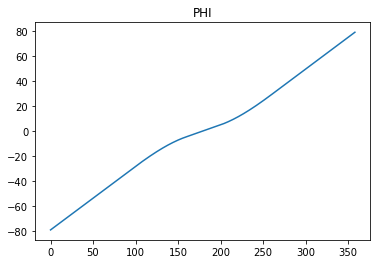

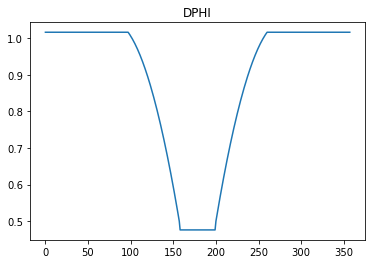

In [33]:
y=cartesian.y[:,0]
LAMBDA=cartesian.x[0,:]
dy=y[1:]-y[0:-1]
jind=np.where(y>-30.)[0][0]
jind=jind+np.mod(jind,2)
y=y[0:jind]
dy=dy[0:jind]

N=31*refine # number of points between -30 and -5 
y_s = y[-1]
dy_s = dy[-1]
y_e = -5.
dy_e = 0.25
nodes = [0,1,N-2,N-1]
y_nodes = [y_s,y_s+dy_s,y_e-dy_e,y_e]
f2=interp1d(nodes,y_nodes,kind=3) # cubic interpolation

jInd2=np.arange(N)
# new array with the interpolated values
y2=f2(jInd2)
#print(y2)
dy2=y2[1:]-y2[0:-1]
# combine both arrays
y=np.concatenate((y[0:-1],y2))
dy=y[1:]-y[0:-1]

# enhance resoliution between -5 and 0 deg latitude
N=11*refine
y_s = y[-1]
y2=np.linspace(y_s,0,N)
dy2=y2[1:]-y2[0:-1]
PHI=np.concatenate((y[0:-1],y2))
PHI=np.concatenate((PHI[0:-1],-PHI[::-1]))
DPHI=PHI[1:]-PHI[0:-1]
# plot PHI and DPHI
plt.figure()
plt.title('PHI')
plt.plot(PHI)
plt.figure()
plt.title('DPHI')
plt.plot(DPHI*refine)
# create final supergrid
x,y = np.meshgrid(LAMBDA,PHI)
grid = supergrid(xdat=x,ydat=y,axis_units='degrees',cyclic_x=True)
grid.grid_metrics()
grid.write_nc('supergrid.nc')

# Plot grid metrics

MOM6 grid was successfully loaded... 

Plotting aspect_ratio... 



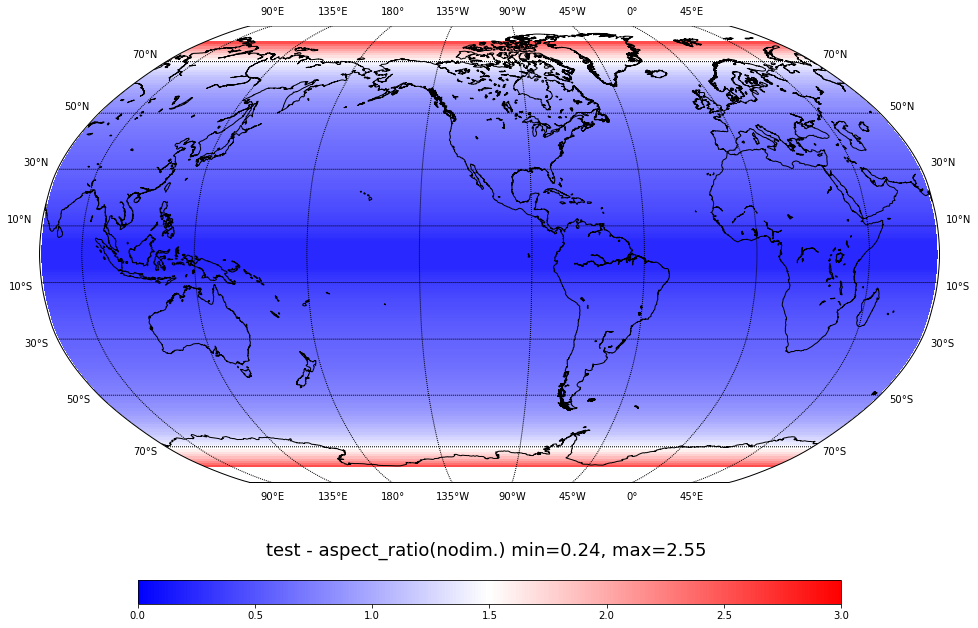

Plotting tarea... 



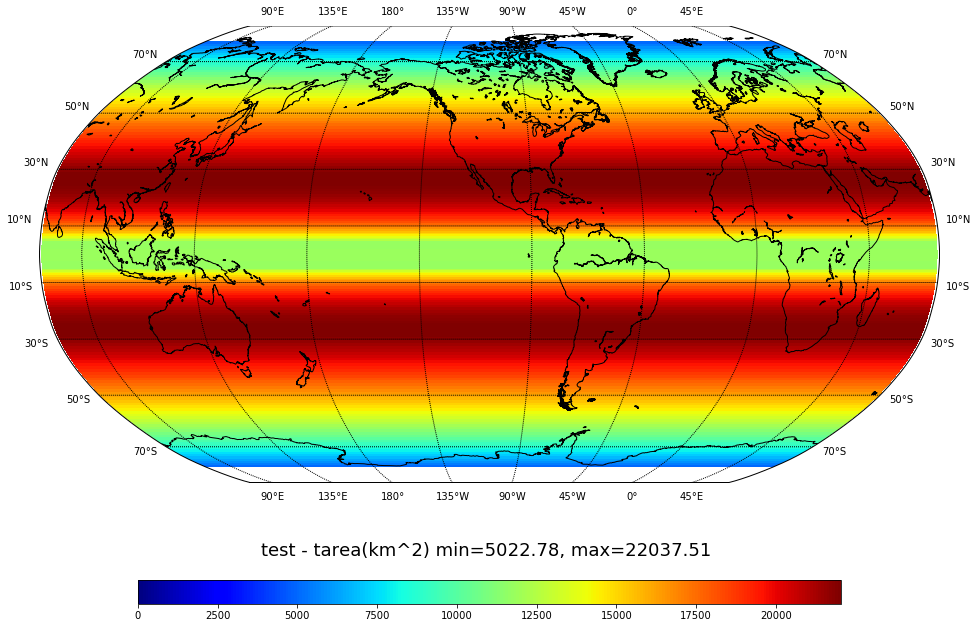

Plotting dx... 



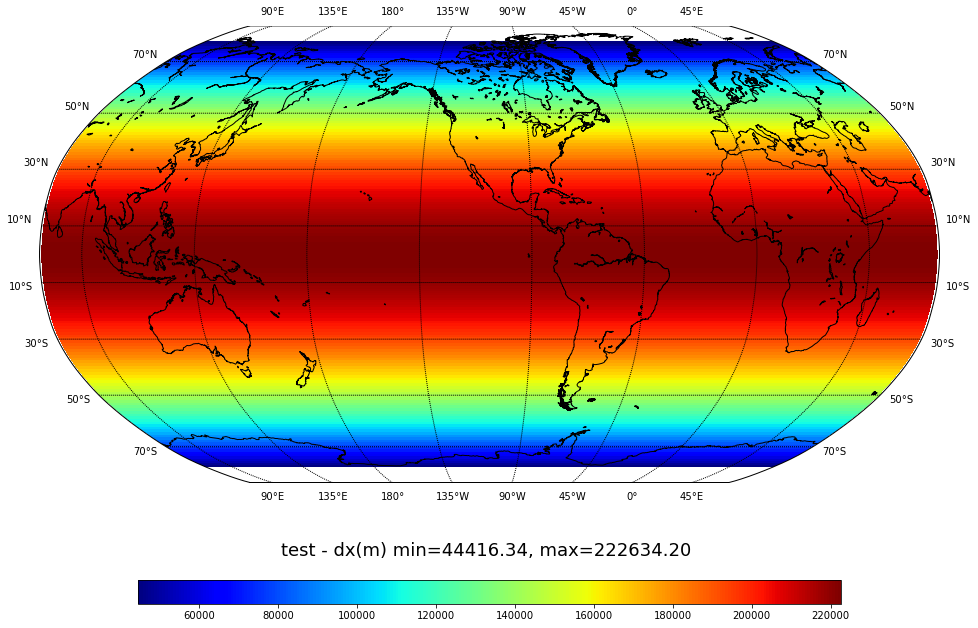

Plotting dy... 



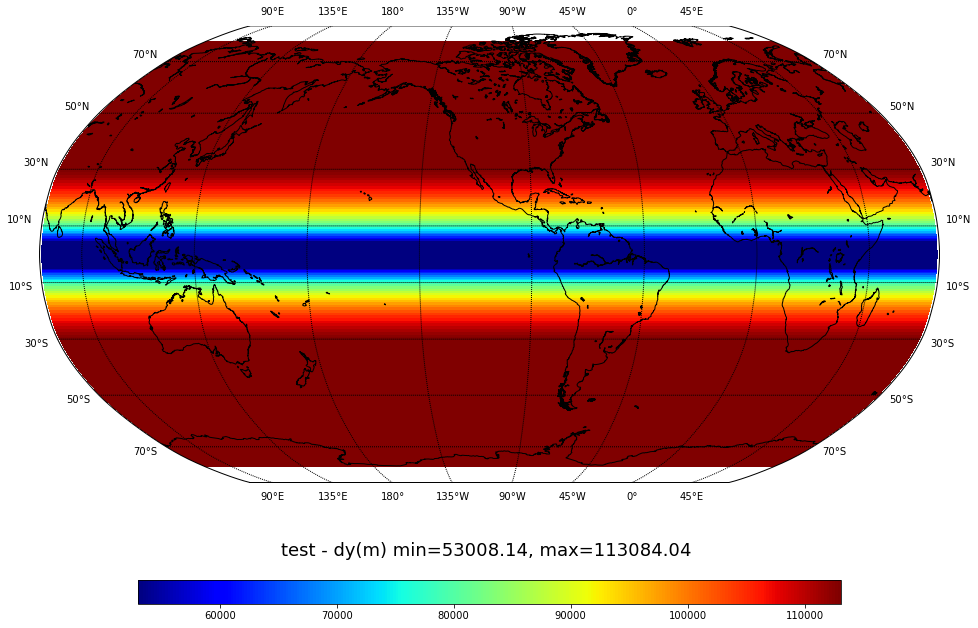

Plotting effective_grid_spacing... 



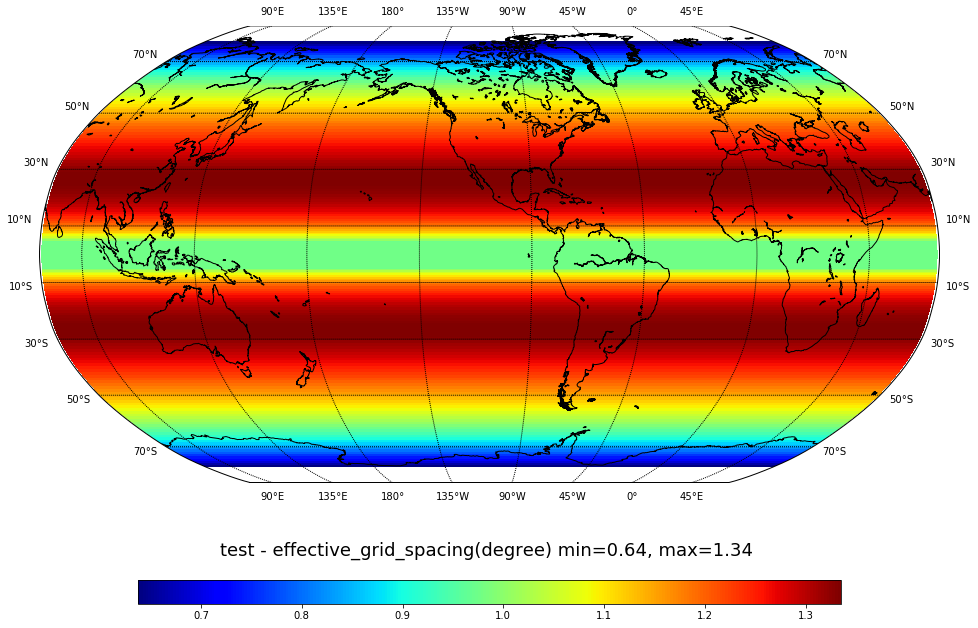

Plotting arctic plot... 

Plotting antarctic plot... 



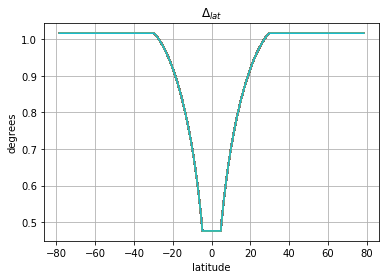

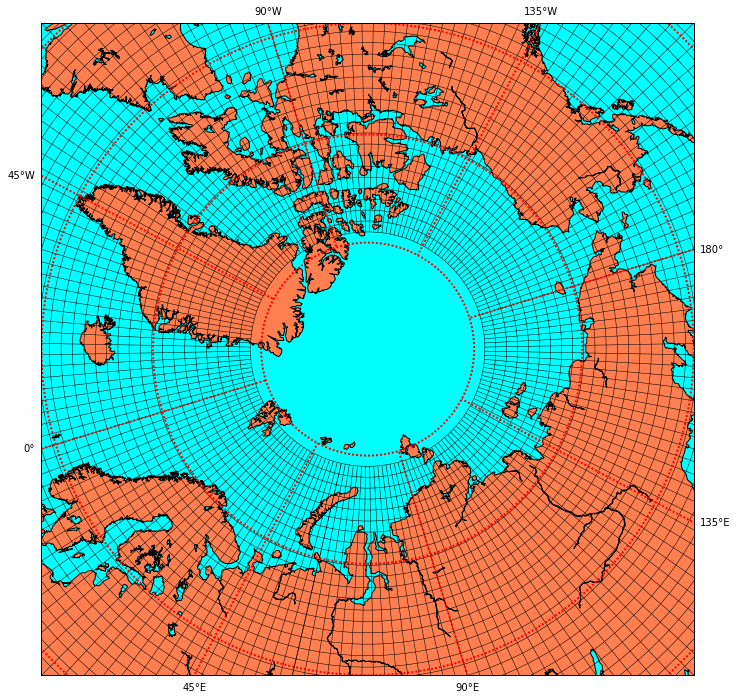

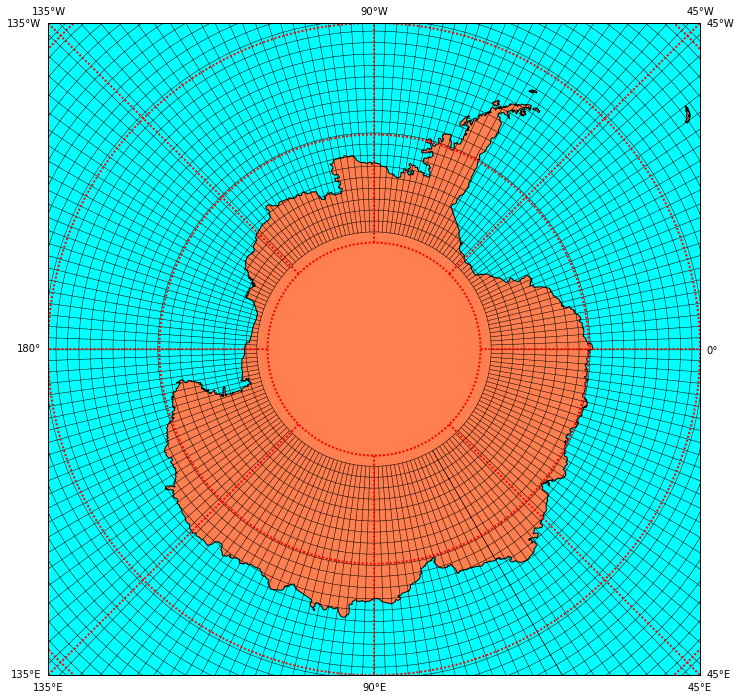

In [26]:
fname = 'supergrid.nc'
nc = netCDF4.Dataset(fname, 'r+')
# add global attributes
nc.Author = 'Gustavo Marques (gmarques@ucar.edu)'
nc.Description = 'MOM6 supergrid file for idealized global experiments'
nc.Created = datetime.now().isoformat()
nc.sync(); nc.close()

# load MOM6 grid
grd = MOM6grid(fname)

# plot aspect ration
ar = grd.dyt / grd.dxt
plot_grid_property(ar, 'aspect_ratio','nodim.', 0, 3, plt.cm.bwr, grd, grid_name)

# plot grid area
tarea = grd.dxt * grd.dyt / 1e6
plot_grid_property(tarea, 'tarea', 'km^2', 0, tarea.max(), plt.cm.jet, grd, grid_name)

# plot dx
plot_grid_property(grd.dxt, 'dx', 'm', grd.dxt.min(), grd.dxt.max(), plt.cm.jet, grd, grid_name)

# plot dy
plot_grid_property(grd.dyt, 'dy', 'm', grd.dyt.min(), grd.dyt.max(), plt.cm.jet, grd, grid_name)

# effective grid spacing
tarea = grd.dxt * grd.dyt
costheta = np.cos(grd.tlat*np.pi/180.)
rearth = 6371220 # Earth radius in meter
dx_deg = (grd.dxt / (rearth * costheta)) * (180./np.pi)
dy_deg = (grd.dyt / rearth) * (180./np.pi)
domega = tarea / rearth**2
egs  = np.sqrt(domega * (180./np.pi)**2)
plot_grid_property(egs, 'effective_grid_spacing', 'degree', egs.min(), egs.max(), plt.cm.jet, grd, grid_name)

# delta lat
plt.figure()
for i in range(grd.tlat.shape[1]):
  plt.plot(grd.tlat[:,i], np.diff(grd.qlat[:,i]))

plt.grid()
plt.title(r'$\Delta_{lat}$')
plt.xlabel('latitude')
plt.ylabel('degrees')

# grid arctic
print('Plotting arctic plot... \n')
m = Basemap(projection='npstere',boundinglat=60,lon_0=73,resolution='l')
x, y = m(grd.qlon, grd.qlat)
plt.figure(figsize=(12,12))
k=1
Basemap.plot(m, x[::k,::k], y[::k,::k], color='k', ls='-', lw=.5)
Basemap.plot(m, x[::k,::k].T, y[::k,::k].T, color='k', ls='-', lw=.5)
m.drawcoastlines()
m.drawmeridians(range(0,360,45), labels=[1,1,1,1],color='r',linewidth=2)
m.drawparallels(range(-90,90,10),color='r',linewidth=2)
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# grid antarctic
print('Plotting antarctic plot... \n')
m = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l')
x, y = m(grd.qlon, grd.qlat)
plt.figure(figsize=(12,12))
k=1
Basemap.plot(m, x[::k,::k], y[::k,::k], color='k', ls='-', lw=.5)
Basemap.plot(m, x[::k,::k].T, y[::k,::k].T, color='k', ls='-', lw=.5)
m.drawcoastlines()
m.drawmeridians(range(0,360,45), labels=[1,1,1,1],color='r',linewidth=2)
m.drawparallels(range(-90,90,10),color='r',linewidth=2)
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# Create a simple topography

ny,nx=  179 180
Plotting Topography... 



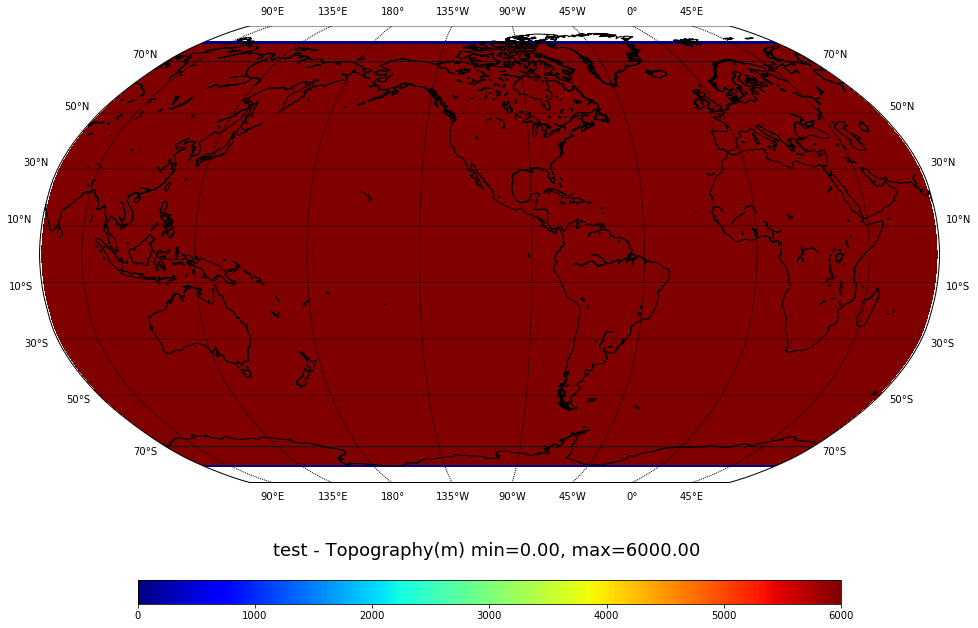

In [36]:
topo=netCDF4.Dataset('topog.nc','w',format='NETCDF3_CLASSIC')
jm=grd.tlat.shape[0]; im = grd.tlat.shape[1]
print('ny,nx= ',jm,im)

# create Dimensions
ny=topo.createDimension('ny',jm)
nx=topo.createDimension('nx',im)
ntiles=topo.createDimension('ntiles',1)    

# create variables
nx=topo.createVariable('nx','f8',('nx'))
ny=topo.createVariable('ny','f8',('ny'))
depth=topo.createVariable('depth','f8',('ny','nx'))

# describe variables (metadata)   
nx.units='degrees_east'
nx.long_name = 'array of longitudes at h points'
ny.units='degrees_north'
ny.long_name = 'array of latitudes at h points'
depth.long_name = 'median grid cell depth'
depth.units = 'm'

# create topography
D = np.ones(grd.tlat.shape) * 6000.0
# add land
D[0:1,:] = 0.0
D[-1::,:] = 0.0
# fill data
depth[:] = D[:]
ny[:]=grd.tlat[:,0]
nx[:]=grd.tlon[0,:]

# map topography
plot_grid_property(D, 'Topography', 'm', 0, D.max(), plt.cm.jet, grd, grid_name)

# sync data and close file
topo.sync()
topo.close()

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-10, 45))
#ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_global()
#ax.gridlines()
#x, y, u, v, vector_crs = sample_data()
#ax.quiver(x, y, u, v, transform=vector_crs)
#plt.show()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2aaaae0aea60> (for post_execute):


URLError: <urlopen error [Errno 110] Connection timed out>

URLError: <urlopen error [Errno 110] Connection timed out>

<Figure size 432x288 with 1 Axes>